In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sopt

def Laplacian(A):
    L = np.zeros(A.shape)
    n = len(A)
    for i in range(n):
        for j in range(n):
            if i==j:
                L[i,j] = np.sum(A[:,j])
            else:
                L[i,j] = -A[i,j]
    return L

def x_dot(x,Theta, B, U_l, V_l):
    x_d = ((Theta + U_l) + np.kron(x.T,np.eye(len(x)))@(B-V_l))@x
    return x_d 


def build_B(n, B_A, Y_cal, Z_cal):
    B = np.zeros((n**2,n))

    n = len(Y_cal)

    for i, (Y_i, Z_i) in enumerate(zip(Y_cal,Z_cal)):
        if Y_i:
            for y in Y_i:
                j, k = y
                B[n*k+i, j] = B_A[j,k]
        
        if Z_i:
            for z in Z_i:
                j, k = z
                B[n*k+i, j] = -B_A[j,k]
    return B

def simulate(numsteps, dt, x0, Theta, B, control=False):
    if not control:
        U = np.zeros(Theta.shape)
        V = np.zeros(B.shape)
        
        x = x0
        xs = [x]
        for _ in range(numsteps):
            x = x + dt*x_dot(x,Theta,B,U,V)
            xs.append(x)
        return xs
    else:
        return None

def advance_flatten(M):
    indices = np.array(list(np.ndindex(M.shape)))
    df = pd.DataFrame({'val': M.flatten(), 'd0': indices[:, 0], 'd1': indices[:, 1]})
    return df

def h(x, I_max, I_cal):
    inds = [i for i in I_cal]
    return I_max - np.sum(x[inds])

def alpha(x):
    return x**2

def d(x, Theta, B):
    print((Theta  + np.kron(x.T,np.eye(len(x)))@B)@x)
    return np.sum((Theta  + np.kron(x.T,np.eye(len(x)))@B)@x)

def solve_UV(x,lam, omg, O_cal, I_cal):
    
    return None


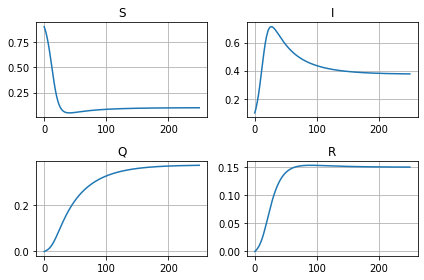

array([0.0994131 , 0.376937  , 0.37349363, 0.15015627])

In [133]:
beta,eta,sigma,gamma,delta = 2,.1,.1,.1,.5

Theta_A = np.array([[0, 0,      0,   delta],
                    [0, 0,      0,     0],
                    [0, eta,    0,     0],
                    [0, gamma, sigma,  0]])

B_A = np.array([[0,     0,  0,  0],
                [beta,  0,  0,  0],
                [0,     0,  0,  0],
                [0,     0,  0,  0]])

n = len(Theta_A)

O_cal = set([0,2,3])
I_cal = set([1])

Z_cal = [set([(1,0)]),set(),set(),set()]
Y_cal = [set(),set([(1,0)]),set(),set()]


Theta_L = -Laplacian(Theta_A)
B_L = build_B(n, B_A, Y_cal, Z_cal)
    

x0 = np.array([.9,0.1,0,0])

numsteps = 250
dt = .1

xs = simulate(numsteps, dt, x0, Theta_L, B_L)

xs_arr = np.array(xs)
labels = ['S','I','Q','R']
plt.figure()
for i in range(n):
    plt.subplot(2,2,i+1)
    plt.plot(xs_arr[:,i])
    plt.grid()
    plt.title(labels[i])

plt.tight_layout()
plt.show()

xs[-1]


In [41]:
inds = [i for i in O_cal]
x0[inds]

array([0.9, 0. , 0. ])

In [10]:
U = np.zeros(Theta_L.shape)
V = np.zeros(B_L.shape)

s_dot = -beta*x0[0]*x0[1] + delta*x0[3]
i_dot = beta*x0[0]*x0[1] - (eta+gamma)*x0[1]
q_dot = eta*x0[1] - sigma*x0[2]
r_dot = gamma*x0[1]+sigma*x0[2] - delta*x0[3]

x_d_check = np.array([s_dot, i_dot, q_dot, r_dot])
x_d = x_dot(x0,Theta_L,B_L,U,V)
print(x_d_check)
print(x_d)


[-0.18  0.16  0.01  0.01]
[-0.18  0.16  0.01  0.01]


In [134]:
O_cal = [0,2,3]
I_cal = [1]

lambdas = (Theta_A > 0).astype(int)
omegas = (B_A > 0).astype(int)

lam_f = advance_flatten(lambdas)
omg_f = advance_flatten(omegas)

omg_f = omg_f[omg_f['val'] > 0]
lam_f = lam_f[(lam_f['val'] > 0) & (lam_f['d1'].isin(I_cal))]

m = len(lam_f)
c = np.concatenate((lam_f['val'].values, omg_f['val'].values))


a_l = x0[lam_f['d1'].values]
a_o = np.array([x0[row['d0']]*x0[row['d1']] for ind, row in omg_f.iterrows()])

a = -np.atleast_2d(np.concatenate((a_l,a_o)))

I_max = 0.1

b = d(x0, Theta_L, B_L) + alpha(h(x0, I_max, I_cal))
print('d(x):', d(x0, Theta_L, B_L))

print('c:', c)
print('a:', a)
print('b:', b)

sol = sopt.linprog(c,a,b,options={'tol':1e-14})
sol
# np.dot(a,sol.x)

# U, V = np.zeros(Theta_A.shape), np.zeros()

# lam_f

[-0.18  0.16  0.01  0.01]
[-0.18  0.16  0.01  0.01]
d(x): 1.3877787807814457e-17
c: [1 1 1]
a: [[-0.1  -0.1  -0.09]]
b: 1.3877787807814457e-17


     con: array([], dtype=float64)
     fun: 1.2086982812983827e-16
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([2.59064721e-17])
  status: 0
 success: True
       x: array([5.75199868e-17, 5.75199868e-17, 5.82985454e-18])

In [15]:
print(lambdas)
print(alphas)


[[0 0 0 1]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 1 0]]
[[0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


In [101]:
import pandas as pd
indices = np.array(list(np.ndindex(Theta_A.shape)))

df = pd.DataFrame({'V': Theta_A.flatten(), 'x': indices[:, 0], 'y': indices[:, 1]})

df

,V,x,y
0,0,0,0
1,0,0,1
2,0,0,2
3,1,0,3
4,0,1,0
5,0,1,1
6,0,1,2
7,0,1,3
8,0,2,0
9,10,2,1
